Create system to automatically recommend content to user based off of their past reads, the input is the current content they are on. 

```
Goal: Represent the products as vectors and use similarity matricies. 
```



# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

In [ ]:
file = files.upload() 

Saving basicTest.csv to basicTest (1).csv


# **Create dataframe and understand parameters**

In [ ]:
data = pd.read_csv("basicTest.csv", delimiter = ',', encoding= 'unicode_escape')

In [ ]:
data.head()

,CourseCode,Description,InvoiceDate,CustomerID
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12/1/10 8:26,17850.0
1,71053,WHITE METAL LANTERN,12/1/10 8:26,17850.0
2,84406B,CREAM CUPID HEARTS COAT HANGER,12/1/10 8:26,17850.0
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,12/1/10 8:26,17850.0
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,12/1/10 8:26,17850.0




```
Course code and the customer ID will be the working vectors
```



# **Preprocess the data**

In [ ]:
# check for missing values
data.isnull()

,CourseCode,Description,InvoiceDate,CustomerID
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
541904,False,False,False,False
541905,False,False,False,False
541906,False,False,False,False
541907,False,False,False,False


In [ ]:
# remove missing values
data.dropna(inplace=True)

# check missing values
data.isnull().sum()

CourseCode     0
Description    0
InvoiceDate    0
CustomerID     0
dtype: int64

In [ ]:
# Check out the number of unique customers in the dataset
customers = data["CustomerID"].unique().tolist()
len(customers)

4372

There are 4372 sequences of readings, so there are a lot more data points. 

# **Split the dataset**

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
# probably should try stratified split
customers_train = [customers[i] for i in range(round(0.8*len(customers)))]

# split data into train and validation set
train_data = data[data['CustomerID'].isin(customers_train)]
validation_data = data[~data['CustomerID'].isin(customers_train)]

# **Populate the vectors with reading history**

In [ ]:
# create a list for reading histories of customers
readingHistory_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_data[train_data["CustomerID"] == i]["CourseCode"].tolist()
    readingHistory_train.append(temp)

100%|██████████| 3498/3498 [00:02<00:00, 1219.41it/s]


In [ ]:
# create a list for reading histories of customers
readingHistory_val = []

# populate the list with the product codes
for i in tqdm(validation_data['CustomerID'].unique()):
    temp = validation_data[validation_data["CustomerID"] == i]["CourseCode"].tolist()
    readingHistory_val.append(temp)

100%|██████████| 874/874 [00:00<00:00, 1894.60it/s]


# **Word2Vector model**

The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.

https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
# model.save("word2vec.model")

# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(readingHistory_train, progress_per=200)

model.train(readingHistory_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3234321, 3268750)

In [ ]:
# save word2vec model
model.save("word2vec_2.model")

IF you don't want to train the model anymore then you can just call it with init_sims()- makes it more memory efficient




In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3135, size=100, alpha=0.03)


# **Extract the vectors of the words and store it as vocabulary**

In [ ]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3135, 100)

# **Visualize**

Reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction.

In [ ]:
#hide
!pip install umap-learn

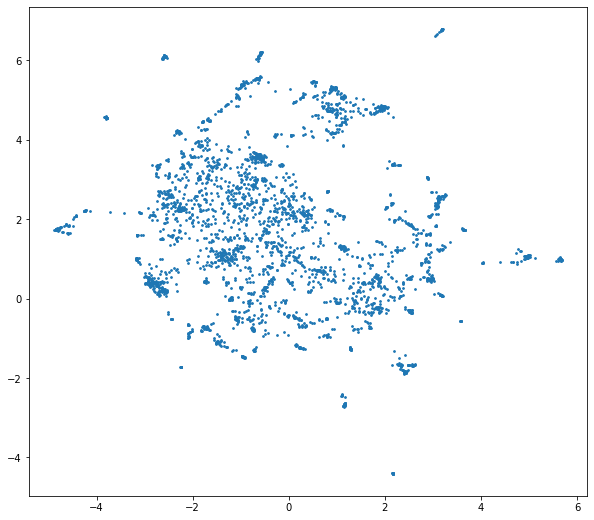

In [ ]:
#collapse
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

# **Create recommendations**

Suggest similar products for a certain product or a product's vector.

The course ID and course description dictionary to map a course description to its ID and vice versa.

In [ ]:
courseCodes = train_data[["CourseCode", "Description"]]

# remove duplicates
courseCodes.drop_duplicates(inplace=True, subset='CourseCode', keep="last")

# create course ids and product-description dictionary
courseCodes_dictionary = courseCodes.groupby('CourseCode')['Description'].apply(list).to_dict()

In [ ]:
# test the dictionary
courseCodes_dictionary['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

Take a product's vector (n) as input and then return top 10 similar products

In [ ]:
def similar_courseCodes(v, n = 10):
    
    # extract most similar course codes for the input vector
    mostSimilar = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar course codes
    new_mostSimilar = []
    for j in mostSimilar:
        pair = (courseCodes_dictionary[j[0]][0], j[1])
        new_mostSimilar.append(pair)
        
    return new_mostSimilar   

In [ ]:
similar_courseCodes(model['90019A'])

[('PINK BOUDICCA LARGE BRACELET', 0.7713759541511536),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7704692482948303),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.768705427646637),
 ('SILVER M.O.P. ORBIT NECKLACE', 0.7376408576965332),
 ('JADE DROP EARRINGS W FILIGREE', 0.7167571783065796),
 ('WOVEN BUBBLE GUM CUSHION COVER', 0.7093976736068726)]

# **Average all of the course vectors**

Take the average of all of the courses the products had done. The idea is that the vector above is based off of one single product

This function gives out a 100 dimensional vector which is the average of the other course vectors in the list. 

In [ ]:
def aggregate_vectors(products):
    courseCode_vector = []
    for i in products:
        try:
            courseCode_vector.append(model[i])
        except KeyError:
            continue
        
    return np.mean(courseCode_vector, axis=0)

In [ ]:
len(readingHistory_val[0])

28

In [ ]:
aggregate_vectors(readingHistory_val[0]).shape

(100,)

Since it returns an array of 100 dimensions then it is working

In [ ]:
similar_courseCodes(aggregate_vectors(readingHistory_val[0]))

[('SET OF 6 RIBBONS VINTAGE CHRISTMAS', 0.6928081512451172),
 ('REGENCY CAKESTAND 3 TIER', 0.6883676052093506),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6779547333717346),
 ("BOX OF 6 MINI 50'S CRACKERS", 0.668990969657898),
 ('BISCUIT TIN VINTAGE CHRISTMAS', 0.6671490669250488),
 ('SET OF 20 VINTAGE CHRISTMAS NAPKINS', 0.6620986461639404)]

In [ ]:
similar_courseCodes(aggregate_vectors(readingHistory_val[0][-10:]))

[("BOX OF 6 MINI 50'S CRACKERS", 0.7980502843856812),
 ('6 GIFT TAGS VINTAGE CHRISTMAS ', 0.7837977409362793),
 ('ROLL WRAP VINTAGE SPOT ', 0.7799862623214722),
 ('ROLL WRAP VINTAGE CHRISTMAS', 0.7795562744140625),
 ('VINTAGE CHRISTMAS GIFT SACK', 0.7731752395629883),
 ('SET OF 6 RIBBONS VINTAGE CHRISTMAS', 0.773095428943634)]

# **Limitations**



*   This algorithm can be applied only for huge datasets that are appropriately labelled. All similarities are based on item profiles, and this is one major limitation. It requires rich item metadata so that they could be compared to other items and recommended properly.
* Model must be re-trained every time for the different business problems (this can also be understood like the model can only make recommendations based on existing interests of the user.)
* Model training is computationally expensive 



# **Sources**



1.   https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/
2.   https://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/
3. https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484
4. https://colab.research.google.com/github/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-24-rec-medium-word2vec.ipynb#scrollTo=59iEesnTzNHq


